In [99]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import mido
import cv2
import os
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import random

## Paths and Constants

In [101]:
# Load data
img_folder = '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI'
midi_folder = '/Users/gesimorris-odubo/Desktop/AI Project/MIDI'
output_directory = 'output'

# Constants
dimension = (128, 128)
canny_low_threshold = 100
canny_high_threshold = 200

# Neural Network structure
input_feature_size = 6
hidden_layer_size = 64
output_parameter_size = 5

# Music parameters for scaling
tempo_range = (60, 100)  # BPM
midi_pitch_range = (48, 72)  # MIDI pitch range
duration_range = (0.5, 2.0)  # Duration in seconds

# Simulated Annealing parameters
sa_initial_temperature = 1.0
sa_cooling_rate = 0.99
sa_iterations = 500

## Extracting Image and MIDI Features

In [102]:
# Extract the features of the images

def extract_features(image_path, target_size=None):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Get the Brightness
    brightness = np.mean(gray)

    # Get the Contrast
    contrast = np.sqrt(np.mean((gray - brightness) ** 2))
    
    # Mean RGB values
    mean_r = np.mean(img[:, :, 2])
    mean_g = np.mean(img[:, :, 1])
    mean_b = np.mean(img[:, :, 0])

    # Edge density
    edges = cv2.Canny(gray, canny_low_threshold, canny_high_threshold)
    edge_density = np.sum(edges) / edges.size

    return np.array([brightness, contrast, mean_r, mean_g, mean_b, edge_density])



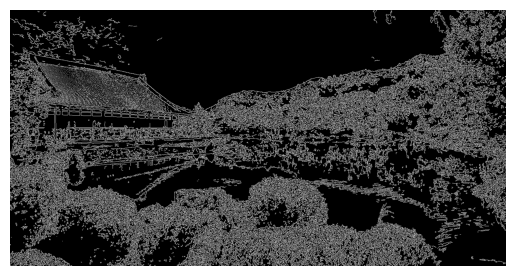

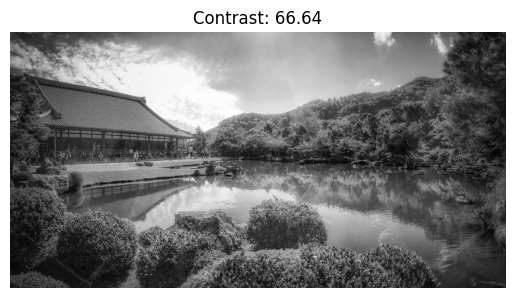

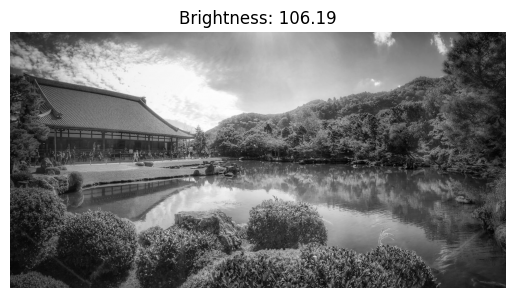

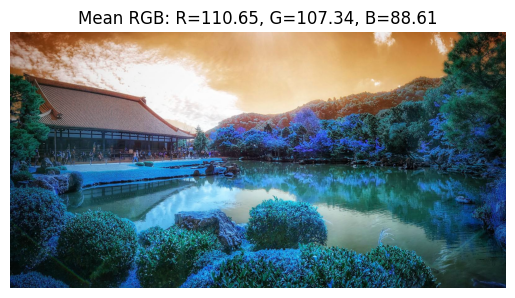

In [133]:
# Show edge density
def show_edge_density(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, canny_low_threshold, canny_high_threshold)
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.show()

# Show the contrast
def show_contrast(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contrast = np.std(gray)
    plt.imshow(gray, cmap='gray')
    plt.title(f'Contrast: {contrast:.2f}')
    plt.axis('off')
    plt.show()

# Show the brightness
def show_brightness(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray)
    plt.imshow(gray, cmap='gray')
    plt.title(f'Brightness: {brightness:.2f}')
    plt.axis('off')
    plt.show()

# Show the mean RGB values
def show_mean_rgb(image_path):
    img = cv2.imread(image_path)
    mean_r = np.mean(img[:, :, 2])
    mean_g = np.mean(img[:, :, 1])
    mean_b = np.mean(img[:, :, 0])
    plt.imshow(img)
    plt.title(f'Mean RGB: R={mean_r:.2f}, G={mean_g:.2f}, B={mean_b:.2f}')
    plt.axis('off')
    plt.show()

# Test the function
path = '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000195_(6).jpg'
show_edge_density(path)
show_contrast(path)
show_brightness(path)
show_mean_rgb(path)


In [103]:
# Extract the midi features

def extract_midi_features(midi_path, default_tempo=80):
    try:
        mid = mido.MidiFile(midi_path)
        microseconds_per_beat = mido.bpm2tempo(default_tempo)      # default tempo
        tempo_bpm = default_tempo
        ticks_per_beat = mid.ticks_per_beat     # ticks per beat

        # find first tempo
        for msg in mid.tracks[0]:
            if msg.is_meta and msg.type == 'set_tempo':    
                microseconds_per_beat = msg.tempo       # tempo in microseconds per beat
                tempo_bpm = mido.tempo2bpm(msg.tempo)   # convert to BPM
                break

        pitches = []
        velocities = []
        durations = []
        note_start_times = []
        absolute_time = 0.0
        active_notes = {}

        for track in mid.tracks:
            absolute_time_ticks = 0     # absolute time in ticks
            for msg in track:
                absolute_time_ticks += msg.time
                # Convert ticks to seconds
                absolute_time = mido.tick2second(absolute_time_ticks, ticks_per_beat, microseconds_per_beat)

                if msg.type == 'note_on' and msg.velocity > 0:
                    note_key = (msg.channel, msg.note)
                    # Store the note start time
                    active_notes[note_key] = absolute_time 
                    # Store the pitch and velocity
                    pitches.append(msg.note)
                    velocities.append(msg.velocity)
                    # Store the start time
                    note_start_times.append(absolute_time)
                elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
                    note_key = (msg.channel, msg.note)
                    if note_key in active_notes:
                        start_time = active_notes.pop(note_key)
                        duration = absolute_time - start_time
                        if duration > 1e-6:
                            durations.append(duration)
        # Stats
        num_notes = len(pitches)
        total_time = max(note_start_times) if note_start_times else 0.0

        if durations:
            last_event_time = max(s + d for s, d in zip(note_start_times[-len(durations):], durations))
            total_time = max(total_time, last_event_time)
        
        # Tempo
        feature_tempo = tempo_bpm
        # Average pitch
        feature_avg_pitch = np.mean(pitches) if pitches else 0
        # Pitch range
        feature_pitch_range = np.max(pitches) - np.min(pitches) if pitches else 0
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            feature_pitch_std = np.std(pitches) if num_notes > 1 else 0.0
        # Pitch class histogram
        pitch_classes = [p % 12 for p in pitches]
        pc_count = Counter(pitch_classes)
        feature_pch = np.array([pc_count.get(i, 0) for i in range(12)])
        feature_pch = feature_pch / num_notes
        # Average velocity
        feature_avg_velocity = np.mean(velocities) if velocities else 0
        # Rythmic density
        feature_rythmic_density = (num_notes / total_time) if total_time > 0 else 0
        # Average duration
        if not durations:
            feature_avg_duration = 0
            feature_duration_std = 0
        else:
            feature_avg_duration = np.mean(durations)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                feature_duration_std = np.std(durations) if len(durations) > 1 else 0.0

        features = np.concatenate([
            np.array([feature_tempo]),
            np.array([feature_avg_pitch]),
            np.array([feature_pitch_range]),
            np.array([feature_pitch_std]),
            feature_pch,
            np.array([feature_avg_velocity]),
            np.array([feature_rythmic_density]),
            np.array([feature_avg_duration]),
            np.array([feature_duration_std]),
        ])
        if np.isnan(features).any() or np.isinf(features).any():
            raise ValueError("Extracted features contain NaN or Inf values.")   # check for NaN or Inf values (e.g. division by zero)
        return features
    except Exception as e:
        print(f"Error processing MIDI file {midi_path}: {e}")
        return None




## Manually Pairing

In [104]:
# Add more for future use
training_pairs = [
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000003_(2).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Eternity MIDI 7 - E Min.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000002_(3).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 1 - C Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000004_(5).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 2 - C Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000005_(7).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 4 - D Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000031_(3).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/1.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000004_(7).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Eternity MIDI 1 - C Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000005_(3).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Eternity MIDI 2 - C Min.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000010_(3).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Eternity MIDI 3 - D Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000010_(4).jpg', 'midi_path': 'MIDI/Cymatics - Eternity MIDI 4 - D Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000032_(3).jpg', 'midi_path': 'MIDI/Cymatics - Eternity MIDI 6 - D Min.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000032.jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Eternity MIDI 7 - E Min.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000033_(5).jpg', 'midi_path': 'MIDI/Cymatics - Eternity MIDI 8 - F Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000034_(5).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 14 - F Min.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000005_(5).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Eternity MIDI 11 - A Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000894_(2).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 22 - B Min.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000889_(3).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Eternity MIDI 15 - A Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000887.jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Eternity MIDI 15 - A Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000885.jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 1 - C Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000884.jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 6 - D Min.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000884_(2).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 2 - C Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000883_(2).jpg' , 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 4 - D Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000881_(2).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Lofi Piano MIDI.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000878_(2).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 18 - G Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000877.jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Lofi Piano MIDI.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000875_(2).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Eternity MIDI 15 - A Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000874.jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 18 - G Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000865_(3).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 12 - E Min.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000854.jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 11 - E Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000848.jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 11 - E Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000847.jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 11 - E Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000844.jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 11 - E Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000841.jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 11 - E Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000843.jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Lofi MIDI 11 - E Maj.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000839.jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Eternity MIDI 7 - E Min.mid'},
    {'image_path': '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000834_(2).jpg', 'midi_path': '/Users/gesimorris-odubo/Desktop/AI Project/MIDI/Cymatics - Eternity MIDI 7 - E Min.mid'}
    
    
]

In [144]:
# Loop through the training pairs and extract features
X_data_list = []
y_data_list = []
valid_pairs_processed = 0

for pair in training_pairs:
    img_path = pair['image_path']
    midi_path = pair['midi_path']
    if os.path.exists(img_path) and os.path.exists(midi_path):
        image_features = extract_features(img_path)
        midi_features = extract_midi_features(midi_path)

        if image_features is not None and midi_features is not None:
            X_data_list.append(image_features)
            y_data_list.append(midi_features)        
            valid_pairs_processed += 1
        else:
            print(f"Skipping pair due to missing features: {pair}")
    else:
        print(f"Skipping pair due to missing files: {pair}")

# Convert to numpy arrays
if valid_pairs_processed > 0:
    X_data = np.array(X_data_list)
    y_data = np.array(y_data_list)

    # Scale image features (x)
    scaler_x = StandardScaler()
    X_scaled = scaler_x.fit_transform(X_data)

    # Scale midi features (y)
    scaler_y = MinMaxScaler(feature_range=(0, 1)) # Scale to [0, 1]
    y_scaled = scaler_y.fit_transform(y_data)




## Generation of the neural network from scratch

In [106]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
    

In [145]:
# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01       # Weight one initialization
        self.b1 = np.zeros((1, hidden_size))        # Bias one initialization
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01      # Weight two initialization
        self.b2 = np.zeros((1, output_size))        # Bias two initialization
        self.learning_rate = learning_rate          # Learning rate initialization

    # Sigmoid activation function
    def sigmoid(self, x):   
        return 1 / (1 + np.exp(-x))

    # Sigmoid derivative
    def sigmoid_derivative(self, x):
        return x * (1 - x)

    # Mean Squared Error (MSE) loss function
    def mean_squared_error(self, y_true, y_pred):
        if y_true.shape != y_pred.shape:    # Check if shapes match
             try:
                 y_true = y_true.reshape(y_pred.shape)
             except ValueError:
                  raise ValueError(f"Shapes don't match: y_pred={y_pred.shape}, y_true={y_true.shape}")
        return np.mean((y_true - y_pred) ** 2)   # MSE calculation

    # Forward pass
    def forward(self, X):
        if X.ndim == 1:
             X = X.reshape(1, -1)
        # Puts the input through the network and in the cache, returns the output
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.sigmoid(self.Z2) # Using sigmoid for output layer
        self.cache = {'Z1': self.Z1, 'A1': self.A1, 'Z2': self.Z2, 'A2': self.A2, 'X': X}
        return self.A2

    # Backward pass
    def backward(self, y_true):
        # Get cached values
        A1 = self.cache['A1']
        A2 = self.cache['A2']
        X = self.cache['X']

        W2 = self.W2 

        m = X.shape[0]

        # Make sure they have the same shape
        if y_true.shape != A2.shape:
            try:
                y_true = y_true.reshape(A2.shape)
            except ValueError:
                 raise ValueError(f"Shape don't match: A2={A2.shape}, y_true={y_true.shape}")

        # Calculate gradients
        # dZ2 is the error at the output layer
        error_output = A2 - y_true
        # dZ2 depends on sigmoid derivative
        dZ2 = error_output * self.sigmoid_derivative(A2)
        dW2 = np.dot(A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = np.dot(dZ2, W2.T) # Use W2 retrieved from self
        # dZ1 depends on sigmoid derivative
        dZ1 = dA1 * self.sigmoid_derivative(A1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        grads = {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2
        }
        return grads

    def update_parameters(self, grads):
        self.W1 -= self.learning_rate * grads['dW1']
        self.b1 -= self.learning_rate * grads['db1']
        self.W2 -= self.learning_rate * grads['dW2']
        self.b2 -= self.learning_rate * grads['db2']

    def train(self, X_train, y_train, epochs, learning_rate, batch_size=32):
        
        history = {'loss': []}
        num_samples = X_train.shape[0]
        batch_size = min(batch_size, num_samples) if batch_size > 0 else num_samples

        print(f"Training started: {epochs} epochs, LR={self.learning_rate}, BatchSize={batch_size}")        # Show training parameters

        for epoch in range(epochs):
            epoch_loss = 0.0

            permutation = np.random.permutation(num_samples)
            # Shuffle the training data
            X_shuffled = X_train[permutation]      
            y_shuffled = y_train[permutation]

            for i in range(0, num_samples, batch_size):
                X_batch = X_shuffled[i:i + batch_size]      # Batch of input features
                y_batch = y_shuffled[i:i + batch_size]      # Batch of target features

                y_pred = self.forward(X_batch)
                loss = self.mean_squared_error(y_batch, y_pred)
                epoch_loss += loss * X_batch.shape[0]
                grads = self.backward(y_batch)
               
                self.update_parameters(grads) 

            average_loss = epoch_loss / num_samples
            history['loss'].append(average_loss)
            # Adjusted print frequency
            if (epoch + 1) % 100 == 0 or epoch == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.6f}")

        print("Training finished.")
        return history

    def predict(self, X):
        return self.forward(X)

print("NeuralNetwork class definition processed.")

NeuralNetwork class definition processed.


X_train shape: (28, 6)
y_train shape: (28, 20)

Hyperparameters:
  Input Size: 6
  Hidden Size: 32
  Output Size: 20
  Learning Rate: 0.01
  Epochs: 1000
  Batch Size: 7

Neural network model initialized successfully.

Starting Training...
Training started: 1000 epochs, LR=0.01, BatchSize=7
Epoch 1/1000, Loss: 0.125813
Epoch 100/1000, Loss: 0.085635
Epoch 200/1000, Loss: 0.084304
Epoch 300/1000, Loss: 0.084068
Epoch 400/1000, Loss: 0.083956
Epoch 500/1000, Loss: 0.083890
Epoch 600/1000, Loss: 0.083845
Epoch 700/1000, Loss: 0.083827
Epoch 800/1000, Loss: 0.083782
Epoch 900/1000, Loss: 0.083747
Epoch 1000/1000, Loss: 0.083735
Training finished.
Training finished.

Plotting Training Loss...


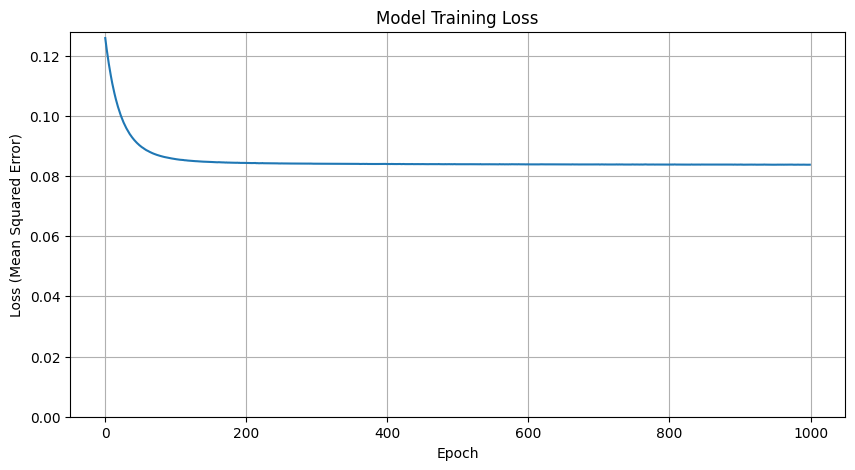


Cell 5 execution finished.


In [146]:


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}") 


try:
     INPUT_SIZE = X_train.shape[1]     
     OUTPUT_SIZE = y_train.shape[1]   
     HIDDEN_SIZE = 32
     LEARNING_RATE = 0.01             
     EPOCHS = 1000                    # Number of training iterations
     
     num_train_samples = X_train.shape[0]
     BATCH_SIZE = min(32, max(1, num_train_samples // 4))

     print("\nHyperparameters:")
     print(f"  Input Size: {INPUT_SIZE}")
     print(f"  Hidden Size: {HIDDEN_SIZE}")
     print(f"  Output Size: {OUTPUT_SIZE}") # Should print 20
     print(f"  Learning Rate: {LEARNING_RATE}")
     print(f"  Epochs: {EPOCHS}")
     print(f"  Batch Size: {BATCH_SIZE}")

     nn_model = NeuralNetwork(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, learning_rate=LEARNING_RATE)
     print("\nNeural network model initialized successfully.")

     print("\nStarting Training...")
        
     training_history = nn_model.train(X_train, y_train, epochs=EPOCHS, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE)
     print("Training finished.")


     if training_history and 'loss' in training_history:
          print("\nPlotting Training Loss...")
          plt.figure(figsize=(10, 5))
          plt.plot(training_history['loss'])
          plt.title('Model Training Loss')
          plt.ylabel('Loss (Mean Squared Error)')
          plt.xlabel('Epoch')
          plt.grid(True)
          plt.ylim(bottom=0) 
          plt.show()
     else:
          print("Could not plot training loss (no history found).")

       

except NameError as ne:
         print(f"Specific error: {ne}")
except Exception as e:
         print(f"\nAn unexpected error occurred during initialization or training: {e}")


print("\nCell 5 execution finished.")
# The 'nn_model' variable now holds your trained neural network (trained for 20 features).
# You also still have 'scaler_X' and the new 'scaler_y' (fitted for 20 features) from Cell 4.

In [147]:
TEMPO_RANGE_CLAMP = (50, 160) # BPM
MIDI_PITCH_RANGE_CLAMP = (36, 96) # MIDI pitch range
VELOCITY_RANGE_CLAMP = (30, 100)  # MIDI velocity range

P_RANGE_CLAMP = (0, 48) # Max reasonable pitch range in semitones
P_STD_CLAMP = (0, 12)  # Max reasonable pitch std dev
R_DENSITY_CLAMP = (0.1, 10) # Notes per second
AVG_DUR_CLAMP = (0.1, 4.0) # Avg duration in seconds
DUR_STD_CLAMP = (0, 2.0)   # Max duration std dev

# Scale the output to music parameters
def scale_output_to_music(scaled_prediction, scaler_y):

    try:
        # Ensure input is 2D for the scaler
        if scaled_prediction.ndim == 1:
            scaled_prediction = scaled_prediction.reshape(1, -1)
        if scaled_prediction.shape[1] != scaler_y.n_features_in_:
             raise ValueError(f"Prediction has {scaled_prediction.shape[1]} features, but scaler_y expects {scaler_y.n_features_in_}")

        # Inverse transform the prediction to get back to original scale
        inverse_scaled = scaler_y.inverse_transform(scaled_prediction)
        
        pred = inverse_scaled.flatten()

        
        tempo = int(round(max(TEMPO_RANGE_CLAMP[0], min(pred[0], TEMPO_RANGE_CLAMP[1]))))
        avg_pitch = int(round(max(MIDI_PITCH_RANGE_CLAMP[0], min(pred[1], MIDI_PITCH_RANGE_CLAMP[1]))))
        pitch_range = max(0, min(pred[2], P_RANGE_CLAMP[1])) 
        pitch_std = max(0, min(pred[3], P_STD_CLAMP[1]))

        pch = pred[4:16] # Extract the 12 PCH values
        pch[pch < 0] = 0
        pch_sum = np.sum(pch)
        if pch_sum > 1e-6:
            pch = pch / pch_sum
        else:
            pch = np.ones(12) / 12.0

        avg_velocity = int(round(max(VELOCITY_RANGE_CLAMP[0], min(pred[16], VELOCITY_RANGE_CLAMP[1]))))
        rhythmic_density = max(R_DENSITY_CLAMP[0], min(pred[17], R_DENSITY_CLAMP[1]))
        avg_duration = max(AVG_DUR_CLAMP[0], min(pred[18], AVG_DUR_CLAMP[1]))
        duration_std = max(0, min(pred[19], DUR_STD_CLAMP[1]))


        # --- Store in Dictionary ---
        music_params = {
            'tempo': tempo,
            'average_pitch': avg_pitch, # Renamed from 'pitch' for clarity
            'pitch_range': pitch_range,
            'pitch_std': pitch_std,
            'pitch_class_histogram': pch, # Store the 12 PCH values
            'average_velocity': avg_velocity,
            'rhythmic_density': rhythmic_density,
            'average_duration': avg_duration,
            'duration_std': duration_std
        }
        return music_params

    except Exception as e:
        print(f"Error during inverse scaling or processing prediction: {e}")
        print(f"Scaled prediction received shape: {scaled_prediction.shape}")
        # Print scaler details if possible
        if hasattr(scaler_y, 'n_features_in_'):
             print(f"Scaler y expects features: {scaler_y.n_features_in_}")
        return None

print("Updated scale_output_to_music function defined (handles 20 features).")

Updated scale_output_to_music function defined (handles 20 features).


In [110]:
MIN_NOTE_DURATION_SEC = 0.1 # Minimum note length in seconds
MAX_NOTE_DURATION_SEC = 2.0 # Maximum note length in seconds

# Create a MIDI file from the generated melody
def create_melody_midi(music_params, filename="ai_generated_lofi_enhanced.mid", target_duration_sec=15):
    """
    Creates a MIDI file attempting to use more predicted features to generate a sequence.

    Args:
        music_params (dict): Dictionary from scale_output_to_music (containing 20 features).
        filename (str): Name of the output MIDI file.
        target_duration_sec (int): Approximate desired duration of the generated sequence.
    """
    try:
        if not music_params:
            print("Music parameters are empty or invalid.")
            return

        # --- Extract parameters from dictionary ---
        tempo = music_params.get('tempo', 80) # Default 80 BPM if missing
        avg_pitch = music_params.get('average_pitch', 60) # Default C4
        pitch_range = music_params.get('pitch_range', 12) # Default 1 octave
        pitch_std = music_params.get('pitch_std', 5) # Default moderate std dev
        pch = music_params.get('pitch_class_histogram', np.ones(12) / 12.0) # Default uniform
        avg_velocity = music_params.get('average_velocity', 70)
        density = music_params.get('rhythmic_density', 2) # Default 2 notes/sec
        avg_duration = music_params.get('average_duration', 0.5) # Default 0.5 sec
        duration_std = music_params.get('duration_std', 0.1)

        # --- Initialize MIDI ---
        mid = mido.MidiFile()
        track = mido.MidiTrack()
        mid.tracks.append(track)
        ticks_per_beat = mid.ticks_per_beat
        microseconds_per_beat = mido.bpm2tempo(tempo)
        track.append(mido.MetaMessage('set_tempo', tempo=microseconds_per_beat))

        # --- Generate Note Sequence ---
        generated_notes = [] # Store tuples of (pitch, duration_sec, velocity)
        current_time_sec = 0.0

        # Calculate target number of notes
        target_num_notes = max(2, int(density * target_duration_sec)) # Ensure at least 2 notes

        last_pitch = int(round(avg_pitch)) # Start near the average pitch

        for i in range(target_num_notes):
            # 1. Choose Pitch for this note
            # Bias choice using Pitch Class Histogram (PCH)
            # Higher probability for notes common in the predicted PCH
            pitch_class = np.random.choice(12, p=pch)

            # Determine octave - try to stay near avg_pitch but allow movement based on std dev
            # Simple approach: Choose octave based on proximity to last_pitch +/- std dev
            pitch_candidate_low = last_pitch - int(round(pitch_std * random.uniform(0.5, 1.5)))
            pitch_candidate_high = last_pitch + int(round(pitch_std * random.uniform(0.5, 1.5)))
            target_pitch_area = random.uniform(pitch_candidate_low, pitch_candidate_high)

            # Find the closest pitch with the chosen pitch_class to the target area
            octave_base = int(round(target_pitch_area / 12.0)) * 12
            pitch = octave_base + pitch_class
            # If too far, try octave below/above
            if abs(pitch - target_pitch_area) > 6:
                 pitch_alt1 = pitch - 12
                 pitch_alt2 = pitch + 12
                 if abs(pitch_alt1 - target_pitch_area) < abs(pitch - target_pitch_area):
                      pitch = pitch_alt1
                 elif abs(pitch_alt2 - target_pitch_area) < abs(pitch - target_pitch_area):
                      pitch = pitch_alt2

            # Clamp pitch to defined range and ensure it's an integer
            pitch = int(round(max(MIDI_PITCH_RANGE_CLAMP[0], min(pitch, MIDI_PITCH_RANGE_CLAMP[1]))))
            last_pitch = pitch # Update for next iteration

            # 2. Choose Duration for this note
            # Sample duration around the average, using std dev, and clamp
            duration_sec = np.random.normal(loc=avg_duration, scale=max(0.01, duration_std)) # Ensure scale > 0
            duration_sec = max(MIN_NOTE_DURATION_SEC, min(duration_sec, MAX_NOTE_DURATION_SEC))

            # 3. Set Velocity
            velocity = int(round(avg_velocity)) # Use average velocity for now

            # Add generated note to list
            generated_notes.append({'pitch': pitch, 'duration': duration_sec, 'velocity': velocity})

            # (Optional: Add small random rest/gap after note? Could base gap on duration_std or density)
            # current_time_sec += duration_sec + random.uniform(0, 0.1) # Example simple gap


        # --- Convert Note Sequence to MIDI Events ---
        absolute_time_ticks = 0
        last_event_end_ticks = 0
        for note in generated_notes:
            pitch = note['pitch']
            duration_sec = note['duration']
            velocity = note['velocity']

            # Calculate start time (add small gap maybe?)
            # Simple sequential placement for now
            start_delta_ticks = max(0, absolute_time_ticks - last_event_end_ticks)
            # For simplicity, let's just put notes one after another with minimal gap if needed
            # A better approach would track absolute time properly
            start_delta_ticks = 5 # Small fixed gap

            # Calculate duration in ticks
            duration_ticks = int(mido.second2tick(duration_sec, ticks_per_beat, microseconds_per_beat))
            duration_ticks = max(1, duration_ticks) # Ensure duration is at least 1 tick

            # Add MIDI messages
            track.append(mido.Message('note_on', note=pitch, velocity=velocity, time=start_delta_ticks))
            track.append(mido.Message('note_off', note=pitch, velocity=velocity, time=duration_ticks))

            # Update time trackers (simplistic tracking)
            absolute_time_ticks += start_delta_ticks + duration_ticks
            last_event_end_ticks = absolute_time_ticks


        # Add end of track message
        track.append(mido.MetaMessage('end_of_track', time=ticks_per_beat)) # Add a final delay

        mid.save(filename)
        print(f"Enhanced MIDI file saved successfully: {filename}")

    except KeyError as e:
         print(f"Error creating MIDI: Missing key {e} in music_params dictionary.")
         print(f"Required keys include: 'tempo', 'average_pitch', 'pitch_range', 'pitch_std', 'pitch_class_histogram', 'average_velocity', 'rhythmic_density', 'average_duration', 'duration_std'")
         print(f"Received keys: {music_params.keys() if music_params else 'None'}")
    except Exception as e:
        print(f"Error creating enhanced MIDI file '{filename}': {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback for debugging

print("Enhanced MIDI creation function (create_melody_midi_enhanced) defined.")

Enhanced MIDI creation function (create_melody_midi_enhanced) defined.


## Fitness Functions

In [111]:
# Calculate fitness
C_MAJOR_SCALE = {0, 2, 4, 5, 7, 9, 11} # MIDI pitch classes: C D E F G A B
A_MINOR_SCALE = {0, 2, 3, 5, 7, 8, 10} # MIDI pitch classes: A B C D E F G (Natural minor used here)

TARGET_SCALE = C_MAJOR_SCALE # Change to A_MINOR_SCALE for minor scale

W_SCALE = 0.3
W_INTERVAL = 0.25
W_RYTHMIC = 0.15
W_PITCH_RANGE = 0.1
W_PITCH_STD = 0.1
W_DURATION = 0.1

def calculate_fitness(melody, music_params):
    pitches = np.array([note['pitch'] for note in melody])
    durations = np.array([note['duration'] for note in melody])
    num_notes = len(melody)

    # Calculate scale fitness
    notes_in_scale = sum(1 for pitch in pitches if (pitch % 12) in TARGET_SCALE)
    scale_fitness = notes_in_scale / num_notes if num_notes > 0 else 0

    # Calculate interval fitness
    intervals = np.abs(np.diff(pitches))
    large_leap_penalty = np.mean(np.maximum(0, intervals - 12)**2) # Penalize intervals larger than an octave
    interval_fitness = 1.0 / (1.0 + large_leap_penalty + 1e-6) # Inverse of penalty

    # Calculate rhythmic density fitness
    target_dur_std = music_params.get('duration_std', 0.1)
    actual_dur_std = np.std(durations) if num_notes > 0 else 0
    if target_dur_std < 1e-6:
        rhythmic_density_fitness = 1.0 if actual_dur_std < 1e-6 else 0.0
    else:
        rhythmic_density_fitness = 1.0 / (1.0 + np.abs(actual_dur_std - target_dur_std) + 1e-6)

    # Calculate pitch range fitness
    target_pitch_range = music_params.get('pitch_range', 12)
    actual_pitch_range = np.max(pitches) - np.min(pitches) if num_notes > 0 else 0
    range_different_penalty = abs(actual_pitch_range - target_pitch_range) / (target_pitch_range + 1e-6) # Penalize difference in range
    pitch_range_fitness = max(0, 1.0 - range_different_penalty)

    # Calculate pitch std fitness
    target_pitch_std = music_params.get('pitch_std', 5)
    actual_pitch_std = np.std(pitches) if num_notes > 1 else 0
    pitch_std_score = 1.0 / (1.0 + np.abs(actual_pitch_std - target_pitch_std) + 1e-6)

    # Calculate average duration fitness
    target_avg_duration = music_params.get('average_duration', 0.5)
    actual_avg_duration = np.mean(durations) if num_notes > 0 else 0
    avg_duration_score = 1.0 / (1.0 + np.abs(actual_avg_duration - target_avg_duration) + 1e-6)

    total_fitness = (
        W_SCALE * scale_fitness +
        W_INTERVAL * interval_fitness +
        W_RYTHMIC * rhythmic_density_fitness +
        W_PITCH_RANGE * pitch_range_fitness +
        W_PITCH_STD * pitch_std_score +
        W_DURATION * avg_duration_score
    )
    return total_fitness



In [88]:
# Neigbor function

MIDI_PITCH_RANGE_CLAMP = (36, 96)
MIN_NOTE_DURATION_SEC = 0.1
MAX_NOTE_DURATION_SEC = 2.0

def get_neighbor(melody):

    neighbor_melody = [note.copy() for note in melody] # Create a copy of the melody
    chosen_index = random.randrange(len(neighbor_melody)) # Randomly select a note to modify

    # Mutations
    mutation_type = random.choice(['pitch', 'duration', 'velocity'])
    if mutation_type == 'pitch':
        # Change pitch using (+/- 1, 2, or 3 semitones common)
        pitch_change = random.choice([-3, -2, -1, 1, 2, 3])
        new_pitch = neighbor_melody[chosen_index]['pitch'] + pitch_change
        # Clamp to MIDI pitch range
        neighbor_melody[chosen_index]['pitch'] = int(round(max(MIDI_PITCH_RANGE_CLAMP[0], min(new_pitch, MIDI_PITCH_RANGE_CLAMP[1]))))

    elif mutation_type == 'duration':
        # Change duration slightly (e.g., +/- 10-30%)
        duration_change = random.uniform(0.7, 1.3)
        new_duration = neighbor_melody[chosen_index]['duration'] * duration_change
        # Clamp to min/max duration
        neighbor_melody[chosen_index]['duration'] = max(MIN_NOTE_DURATION_SEC, min(new_duration, MAX_NOTE_DURATION_SEC))

    elif mutation_type == 'velocity':
        # Change velocity slightly (e.g., +/- 10-30%)
        velocity_change = random.choice([-20, -10, 10, 20])
        new_velocity = neighbor_melody[chosen_index]['velocity'] + velocity_change
        # Clamp to MIDI velocity range
        neighbor_melody[chosen_index]['velocity'] = max(0, min(new_velocity, 127))
    
    return neighbor_melody

In [89]:
# Hill Climbing Algorithm

def hill_climbing(melody, music_params, max_iterations=1000):
    current_melody = melody
    current_fitness = calculate_fitness(current_melody, music_params)

    for iteration in range(max_iterations):
        neighbor_melody = get_neighbor(current_melody)
        neighbor_fitness = calculate_fitness(neighbor_melody, music_params)

        if neighbor_fitness > current_fitness:
            current_melody = neighbor_melody
            current_fitness = neighbor_fitness

    return current_melody

In [112]:
# Simulated Annealing Algorithm
import math

def simulated_annealing(melody, music_params, initial_temp=1.0, cooling_rate=0.995, max_iterations=3000):

    current_melody = melody
    current_fitness = calculate_fitness(current_melody, music_params)
    best_melody = current_melody
    best_fitness = current_fitness
    temp = initial_temp

    for iteration in range(max_iterations):

        # Generate a neighbor melody
        neighbor_melody = get_neighbor(current_melody)
        neighbor_fitness = calculate_fitness(neighbor_melody, music_params)

        # Calculate change in fitness
        fitness_change = neighbor_fitness - current_fitness

        if fitness_change > 0:
            # Accept the neighbor melody
            current_melody = neighbor_melody
            current_fitness = neighbor_fitness
        else:
            if temp > 1e-6:
                acceptance_probability = math.exp(fitness_change / temp)
                if random.random() < acceptance_probability:
                    current_melody = neighbor_melody
                    current_fitness = neighbor_fitness
        
        if current_fitness > best_fitness:
            best_melody = current_melody
            best_fitness = current_fitness
        
        # Cool down the temperature
        temp *= cooling_rate

    return best_melody

      

In [113]:

def generate_initial_sequence(music_params, target_duration=15):
    avg_pitch = music_params.get('average_pitch', 60)
    avg_velocity = music_params.get('average_velocity', 70)
    avg_duration = music_params.get('average_duration', 0.5)
    rhythmic_density = music_params.get('rhythmic_density', 2)
    duration_std = music_params.get('duration_std', 0.1)
    pitch_std = music_params.get('pitch_std', 5)
    pch = music_params.get('pitch_class_histogram', np.ones(12) / 12.0)

    generated_notes = []
    target_num_notes = max(2, int(rhythmic_density * target_duration)) # Ensure at least 2 notes
    last_pitch = int(round(avg_pitch)) # Start near the average pitch

    for i in range(target_num_notes):
        # 1. Choose Pitch for this note
        pitch_class = np.random.choice(12, p=pch)
        pitch_candidate_low = last_pitch - int(round(pitch_std * random.uniform(0.5, 1.5)))
        pitch_candidate_high = last_pitch + int(round(pitch_std * random.uniform(0.5, 1.5)))
        target_pitch_area = random.uniform(pitch_candidate_low, pitch_candidate_high)
        octave_base = int(round(target_pitch_area / 12.0)) * 12
        pitch = octave_base + pitch_class
        if abs(pitch - target_pitch_area) > 6:
            pitch_alt1 = pitch - 12
            pitch_alt2 = pitch + 12
            if abs(pitch_alt1 - target_pitch_area) < abs(pitch - target_pitch_area):
                pitch = pitch_alt1
            elif abs(pitch_alt2 - target_pitch_area) < abs(pitch - target_pitch_area):
                pitch = pitch_alt2

        # Clamp pitch to defined range and ensure it's an integer
        pitch = int(round(max(MIDI_PITCH_RANGE_CLAMP[0], min(pitch, MIDI_PITCH_RANGE_CLAMP[1]))))
        last_pitch = pitch

        # 2. Choose Duration for this note
        duration_sec = np.random.normal(loc=avg_duration, scale=max(0.01, duration_std)) # Ensure scale > 0
        duration_sec = max(MIN_NOTE_DURATION_SEC, min(duration_sec, MAX_NOTE_DURATION_SEC))

        # 3. Set Velocity
        velocity = int(round(avg_velocity)) # Use average velocity for now

        # Add generated note to list
        generated_notes.append({'pitch': pitch, 'duration': duration_sec, 'velocity': velocity})

    return generated_notes


def write_melody_to_midi(sequence, music_params, filename="refined_melody.mid"):

    mid = mido.MidiFile()
    track = mido.MidiTrack()
    mid.tracks.append(track)

    tempo = music_params.get('tempo', 80) # Default 80 BPM if missing
    ticks_per_beat = mid.ticks_per_beat
    microseconds_per_beat = mido.bpm2tempo(tempo)
    track.append(mido.MetaMessage('set_tempo', tempo=microseconds_per_beat))

    absolute_time_ticks = 0
    last_event_end_ticks = 0
    for note in sequence:
        pitch = note.get('pitch', 60) # Default to middle C if missing
        duration_sec = note.get('duration', 0.5) # Default to 0.5 sec if missing
        velocity = note.get('velocity', 70) # Default to 70 if missing

        # Calculate start time (add small gap maybe?)
        start_delta_ticks = 5 if absolute_time_ticks > 0 else 0
        absolute_time_ticks += start_delta_ticks

        # Calculate duration in ticks
        duration_ticks = int(mido.second2tick(duration_sec, ticks_per_beat, microseconds_per_beat))
        duration_ticks = max(1, duration_ticks) # Ensure duration is at least 1 tick

        # Add MIDI messages
        track.append(mido.Message('note_on', note=pitch, velocity=velocity, time=start_delta_ticks))
        track.append(mido.Message('note_off', note=pitch, velocity=velocity, time=duration_ticks))

        last_event_end_ticks = absolute_time_ticks + duration_ticks
        absolute_time_ticks = last_event_end_ticks

    # Add end of track message
    track.append(mido.MetaMessage('end_of_track', time=ticks_per_beat)) # Add a final delay
    mid.save(filename)
    print(f"Refined MIDI file saved successfully: {filename}")



In [134]:
def generate_music_from_image(image_path, model, scaler_x, scaler_y, output_filename="ai_generated_lofi.mid", sa_iterations=5000, sa_temp=0.5, sa_cool=0.997, target_duration=15):
    try:
        # Extract features from the image
        image_features = extract_features(image_path)
        image_features2d = image_features.reshape(1, -1)
        # Scale the image features
        
        image_features_scaled = scaler_x.transform(image_features2d)
        # Predict the music using the model
        predicted_music = model.predict(image_features_scaled)
        # Inverse scale the predicted music
        music_params = scale_output_to_music(predicted_music, scaler_y)
        print("Predicted music parameters:", music_params)
        
        initial_melody = generate_initial_sequence(music_params, target_duration=target_duration)
        print("Initial melody generated:", initial_melody)

        # Refine the melody using simulated annealing
        refined_melody = simulated_annealing(initial_melody, music_params, max_iterations=sa_iterations, initial_temp=sa_temp, cooling_rate=sa_cool)
        print("Refined melody:", refined_melody)

        # Save the melody to a MIDI file
        write_melody_to_midi(refined_melody, music_params, filename=output_filename)
        print(f"Generated music saved to {output_filename}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Graph difference between intital melody and refined melody
def plot_melody_difference(initial_melody, refined_melody):
    initial_pitches = [note['pitch'] for note in initial_melody]
    refined_pitches = [note['pitch'] for note in refined_melody]

    plt.figure(figsize=(12, 6))
    plt.plot(initial_pitches, label='Initial Melody', alpha=0.5)
    plt.plot(refined_pitches, label='Refined Melody', alpha=0.8)
    plt.title('Melody Pitch Comparison')
    plt.xlabel('Note Index')
    plt.ylabel('MIDI Pitch')
    plt.legend()
    plt.grid()
    plt.show()


        



## TEST 


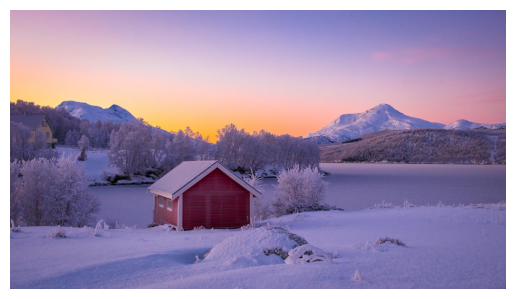

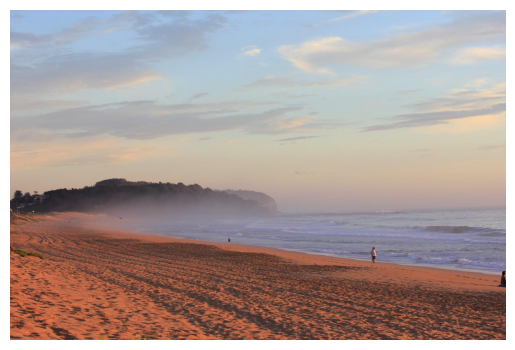

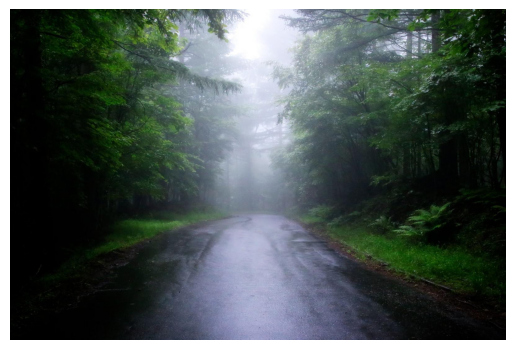

Predicted music parameters: {'tempo': 80, 'average_pitch': 64, 'pitch_range': 31.364098565051872, 'pitch_std': 8.285114240917272, 'pitch_class_histogram': array([0.09540277, 0.07306298, 0.09641232, 0.06870732, 0.08836443,
       0.07019648, 0.10817909, 0.09577234, 0.06779528, 0.1003409 ,
       0.0423464 , 0.0934197 ]), 'average_velocity': 59, 'rhythmic_density': 3.50497488905961, 'average_duration': 1.5252608790524458, 'duration_std': 0.7095234561710501}
Initial melody generated: [{'pitch': 57, 'duration': 1.5171311816179114, 'velocity': 59}, {'pitch': 57, 'duration': 0.7541411241218331, 'velocity': 59}, {'pitch': 57, 'duration': 2.0, 'velocity': 59}, {'pitch': 56, 'duration': 0.8826352334824331, 'velocity': 59}, {'pitch': 67, 'duration': 2.0, 'velocity': 59}, {'pitch': 66, 'duration': 2.0, 'velocity': 59}, {'pitch': 64, 'duration': 0.7453608399527547, 'velocity': 59}, {'pitch': 64, 'duration': 1.4654339178005376, 'velocity': 59}, {'pitch': 67, 'duration': 2.0, 'velocity': 59}, {'pitc

In [138]:


test1_image_path = '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000032_(3).jpg'
test_image_path = '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000044_(4).jpg' # Variable name kept as 'test_image_path' from your original example
test3_image_path = '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000010_(7).jpg'


output_filename1 = "ai_generated_lofi_1.mid"
output_filename2 = "ai_generated_lofi_2.mid"
output_filename3 = "ai_generated_lofi_3.mid"

# Show the images
def show_image(image_path):
    try:
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error displaying image {image_path}: {e}")
# Show the images
show_image(test1_image_path)
show_image(test_image_path)
show_image(test3_image_path)


generate_music_from_image(test1_image_path, nn_model, scaler_x, scaler_y, output_filename=output_filename1)
generate_music_from_image(test_image_path, nn_model, scaler_x, scaler_y, output_filename=output_filename2)
generate_music_from_image(test3_image_path, nn_model, scaler_x, scaler_y, output_filename=output_filename3)




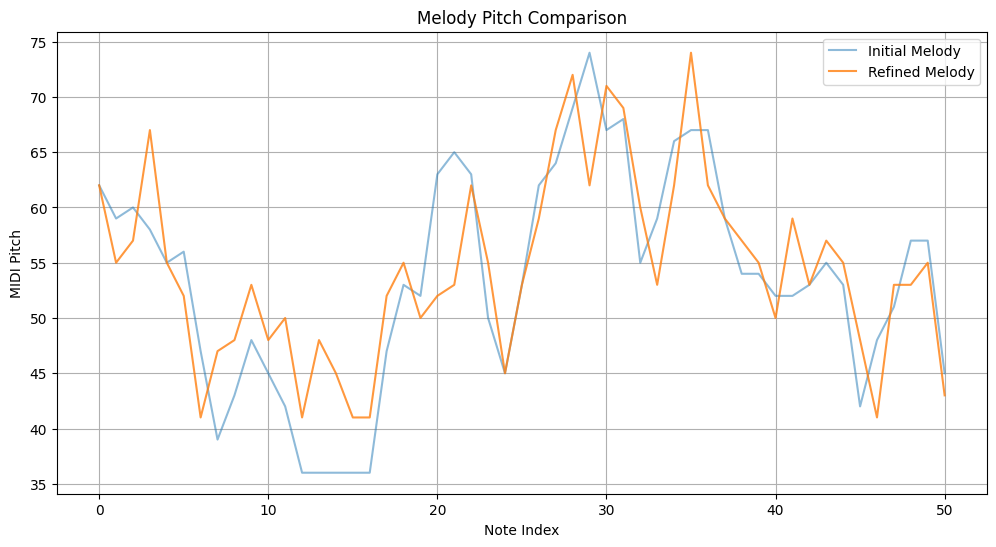

In [135]:
# Plot Melody Differences

initial_melody1 = generate_initial_sequence(scale_output_to_music(nn_model.predict(scaler_x.transform(extract_features(test1_image_path).reshape(1, -1))), scaler_y))
refined_melody1 = simulated_annealing(initial_melody1, scale_output_to_music(nn_model.predict(scaler_x.transform(extract_features(test1_image_path).reshape(1, -1))), scaler_y))
plot_melody_difference(initial_melody1, refined_melody1)

In [143]:
# Plot pitch histogram
def plot_pitch_histogram(melody, title="Pitch Histogram"):
    pitches = [note['pitch'] for note in melody]
    plt.figure(figsize=(10, 5))
    plt.hist(pitches, bins=range(36, 97), alpha=0.7, color='blue', edgecolor='black')
    plt.title(title)
    plt.xlabel('MIDI Pitch')
    plt.ylabel('Frequency')
    plt.xticks(range(36, 97))
    plt.grid(axis='y')
    plt.show()


## Fourier Analysis

Starting FFT comparison...
Processing Reference: generic_reference_file.wav
Processing AI Output: ai_reference_file.wav
         Ensure WAV files were created with the same sample rate for accurate comparison.
         Ref Length: 360010, AI Length: 1623572

Plotting spectral comparison...


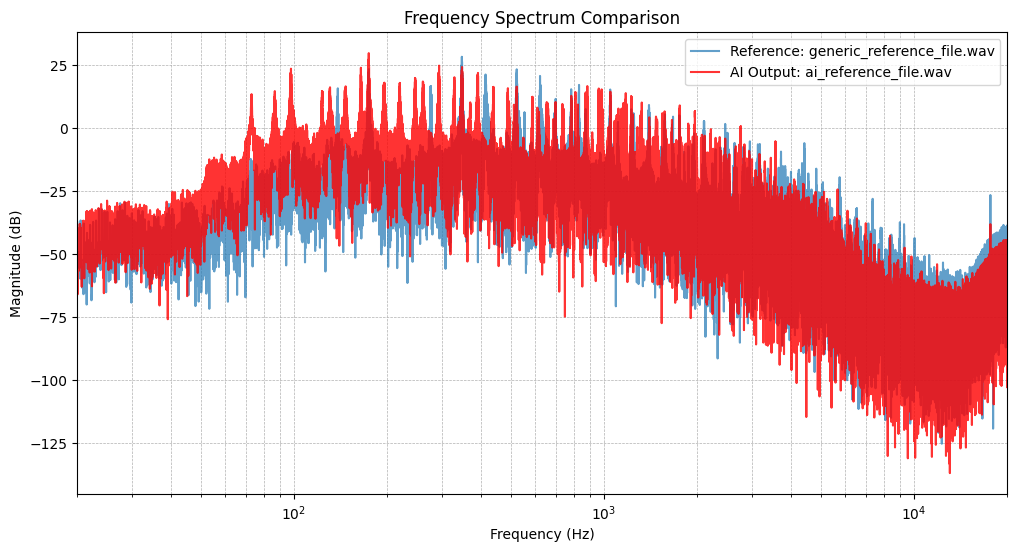


FFT Analysis Cell finished.


In [140]:
# Cell 9: FFT Analysis - Specific File Comparison

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile # Reads WAV files
from scipy.fft import fft, fftfreq # Calculates FFT
import os
import warnings # To handle potential numpy warnings cleanly

# --- File Paths ---
# Reference Lofi Audio File (Make sure this path is correct and the file exists)
lofi_reference_file = '/Users/gesimorris-odubo/Desktop/AI Project/generic_reference_file.wav'

# Your AI Generated Audio File (Make sure this path is correct and the file exists)
# This MUST be an audio file (e.g., WAV), rendered from your AI's MIDI output.
ai_reference_file = '/Users/gesimorris-odubo/Desktop/AI Project/ai_reference_file.wav' # Using the 3rd output file as requested

# --- Helper Function to Compute Spectrum ---
def get_average_spectrum(audio_path, max_freq_hz=20000):
    """Loads WAV, computes FFT, returns positive frequencies and magnitudes."""
    try:
        samplerate, data = wavfile.read(audio_path)
        # Convert to mono if stereo
        if data.ndim > 1:
            data = data.mean(axis=1)
        n_samples = len(data)
        if n_samples == 0:
            print(f"Warning: Empty audio file {audio_path}")
            return None, None

        yf = fft(data)
        xf = fftfreq(n_samples, 1 / samplerate)

        # Keep only positive frequencies
        positive_mask = xf >= 0
        xf_pos = xf[positive_mask]
        # Normalize magnitude roughly by number of samples
        yf_mag = np.abs(yf[positive_mask]) / n_samples

        # Optional: Limit frequency range analysis
        if max_freq_hz is not None:
             freq_mask = xf_pos <= max_freq_hz
             xf_pos = xf_pos[freq_mask]
             yf_mag = yf_mag[freq_mask]

        return xf_pos, yf_mag
    except FileNotFoundError:
        print(f"ERROR: Audio file not found at {audio_path}")
        return None, None
    except Exception as e:
        print(f"ERROR processing audio file {audio_path}: {e}")
        return None, None

# --- Process Files and Plot ---
print("Starting FFT comparison...")
plot_generated = False

# Check if files exist before proceeding
if not os.path.exists(lofi_reference_file):
    print(f"ERROR: Reference file not found: {lofi_reference_file}")
elif not os.path.exists(ai_reference_file):
    print(f"ERROR: AI audio file not found: {ai_reference_file}")
    print(f"       Ensure you have rendered the corresponding MIDI file ('{os.path.splitext(ai_reference_file)[0]}.mid'?) to WAV.")
else:
    # Process Reference File
    print(f"Processing Reference: {os.path.basename(lofi_reference_file)}")
    ref_freqs, ref_mag = get_average_spectrum(lofi_reference_file)

    # Process AI Generated File
    print(f"Processing AI Output: {os.path.basename(ai_reference_file)}")
    ai_freqs, ai_mag = get_average_spectrum(ai_reference_file)

    # Check if processing was successful for both
    if ref_freqs is not None and ref_mag is not None and ai_freqs is not None and ai_mag is not None:

         # Simple check for potential sample rate mismatch affecting comparison
         if len(ref_freqs) != len(ai_freqs):
              print("Warning: Number of frequency components differ between files.")
              print("         Ensure WAV files were created with the same sample rate for accurate comparison.")
              print(f"         Ref Length: {len(ref_freqs)}, AI Length: {len(ai_freqs)}")
              # Plotting might still work but could be misleading if scales differ wildly.
              # More robust comparison would use librosa.load(sr=...) or interpolation.

         print("\nPlotting spectral comparison...")
         plt.figure(figsize=(12, 6))

         # Convert magnitude to dB (Decibels) for standard visualization
         # Add a small value (epsilon) to avoid log10(0)
         epsilon = 1e-9
         ref_db = 20 * np.log10(ref_mag + epsilon)
         ai_db = 20 * np.log10(ai_mag + epsilon)

         # Plotting - use frequency points specific to each file
         plt.plot(ref_freqs, ref_db, label=f'Reference: {os.path.basename(lofi_reference_file)}', alpha=0.7)
         plt.plot(ai_freqs, ai_db, label=f'AI Output: {os.path.basename(ai_reference_file)}', alpha=0.8, color='red')

         # Formatting
         plt.xscale('log') # Logarithmic scale for frequency is standard
         plt.xlabel('Frequency (Hz)')
         plt.ylabel('Magnitude (dB)')
         plt.title('Frequency Spectrum Comparison')
         plt.legend()
         plt.grid(True, which='both', linestyle='--', linewidth=0.5)
         plt.xlim(20, 20000) # Limit to typical human hearing range
         # Adjust y-limit based on results if needed for better visibility
         # y_min = min(np.min(ref_db), np.min(ai_db)) - 10
         # y_max = max(np.max(ref_db), np.max(ai_db)) + 10
         # plt.ylim(max(y_min, -120), y_max) # Example adjustment

         plt.show()
         plot_generated = True

    else:
         print("Could not plot comparison due to errors processing audio files.")

if not plot_generated:
     print("Spectral comparison plot was not generated.")

print("\nFFT Analysis Cell finished.")

## Human Evaluation

In [136]:
# Table of results
import pandas as pd
import os
from scipy import stats

# Create a DataFrame to hold the results
results = {
    'TrialID': ['Trial 1', 'Trial 2', 'Trial 3', 'Trial 4', 'Trial 5', 'Trial 6', 'Trial 7', 'Trial 8', 'Trial 9', 'Trial 10'],
    'Image': [test1_image_path, test_image_path, test3_image_path, 
              '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000855_(2).jpg',
              '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000855_(3).jpg',
              '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000861.jpg',
              '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/00000861_(2).jpg',
              '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/test_image_1.jpg',
              '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/test_image_2.jpg',
              '/Users/gesimorris-odubo/Desktop/AI Project/ImagesAI/test_image_3.jpg'],
    'AIRating': [8, 8, 9, 7, 7, 9, 8, 8, 7, 8],
    'GenericRating': [7, 8, 8, 6, 7, 8, 7, 8, 7, 8],
    
}

# Create DataFrame
results_df = pd.DataFrame(results)
results_df['Difference'] = results_df['AIRating'] - results_df['GenericRating']

ai_scores = results_df['AIRating']
generic_scores = results_df['GenericRating']

# Perform t-test
t_stat, p_value = stats.ttest_ind(ai_scores, generic_scores)
alpha = 0.05 # Significance level
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Check if the null hypothesis can be rejected
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between AI and generic ratings.")
else:
    print("Fail to reject the null hypothesis: No significant difference between AI and generic ratings.")

T-statistic: 1.5554275420956378, P-value: 0.13725108337569444
Fail to reject the null hypothesis: No significant difference between AI and generic ratings.


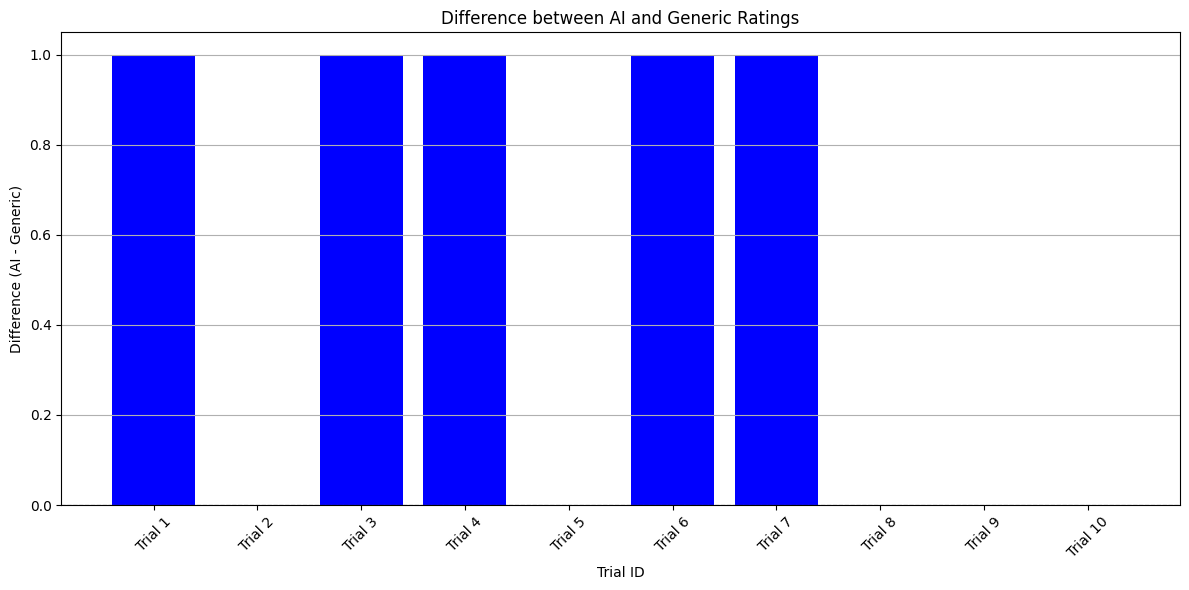

In [137]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(results_df['TrialID'], results_df['Difference'], color=['blue' if x > 0 else 'red' for x in results_df['Difference']])
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Difference between AI and Generic Ratings')
plt.xlabel('Trial ID')
plt.ylabel('Difference (AI - Generic)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
